In [1]:
from net.parse import *
from net import *

In [2]:
DELTA = 3
CONTEXT = 10

In [3]:
# Build dataset
trends = merge_on_date(parse_path(Path('../data/trends'))) # Parse trends data
stats = get_data() # Parse stats data
x_train, y_train, x_test, y_test, mean, std = build_data(trends, stats, DELTA, CONTEXT)

/Users/tudor/CS-Work/ML/P3/VFNN/src/net/parse/finance_parser.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  daily = yf.download(tickers='^SPX', start=start, end=end, interval='1d')
[*********************100%***********************]  1 of 1 completed


In [4]:
# Model Hyperparameters
HIDDEN = 256
INPUT_SIZE = 28 # Fixed
MLP_SIZE = (256, 512, 1) # Has to end in 1
BATCH_SIZE = 64
STEPS = 10000
LR = 1e-2
LAMBDA_ = 1e-4

In [5]:
# Initialize
model = VFNN(HIDDEN, INPUT_SIZE, MLP_SIZE)

In [6]:
def hybrid_loss(preds, targets, alpha=0.5):
    return alpha * MAE(preds, targets) + (1 - alpha) * RMSE(preds, targets)

Loss: 0.1166626587510109 on step: 1
Loss: 0.045651085674762726 on step: 101
Loss: 0.08654549717903137 on step: 201
Loss: 0.1365014761686325 on step: 301
Loss: 0.04964638501405716 on step: 401
Loss: 0.12708881497383118 on step: 501
Loss: 0.0466463603079319 on step: 601
Loss: 0.05831177532672882 on step: 701
Loss: 0.035527292639017105 on step: 801
Loss: 0.04183793067932129 on step: 901
Loss: 0.04132639616727829 on step: 1001
Loss: 0.10295604169368744 on step: 1101
Loss: 0.0865936428308487 on step: 1201
Loss: 0.041421450674533844 on step: 1301
Loss: 0.06574069708585739 on step: 1401
Loss: 0.04871920868754387 on step: 1501
Loss: 0.11963509023189545 on step: 1601
Loss: 0.06709275394678116 on step: 1701
Loss: 0.08927921950817108 on step: 1801
Loss: 0.05100487917661667 on step: 1901
Loss: 0.04633072763681412 on step: 2001
Loss: 0.04762453958392143 on step: 2101
Loss: 0.04956881329417229 on step: 2201
Loss: 0.07982213795185089 on step: 2301
Loss: 0.06621836125850677 on step: 2401
Loss: 0.04996

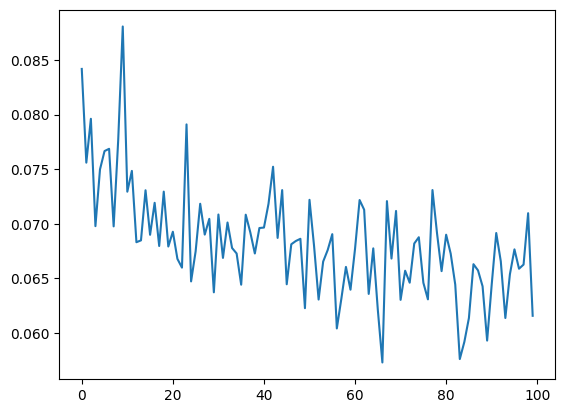

In [14]:
# Train
model.train()
lossi = adam(model, hybrid_loss, x_train, y_train, LR * 0.1, LAMBDA_, BATCH_SIZE, STEPS)

# Plot loss
from matplotlib import pyplot as plt
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))

In [ ]:
def MAPE_test(preds: torch.Tensor, acc: torch.Tensor):
    """
    Mean absolute percentage error
    """
    return 100 * torch.abs((preds - acc) / (torch.abs(acc) + torch.abs(preds))).mean()


In [78]:
model.eval()
vals = model.forward(x_train)
percents = (vals.flatten() * std[:, -2] + mean[:, -2]) / 1e4
targs = (y_train.flatten() * std[:, -2] + mean[:, -2]) / 1e4
loss = RMSE(percents, targs)
print(loss.item())
print(MAPE_test(percents, targs).item())

0.0017427009297534823
16.244842529296875


In [79]:
model.eval()
vals = model.forward(x_test)
percents = (vals.flatten() * std[:, -2] + mean[:, -2]) / 1e4
targs = (y_test.flatten() * std[:, -2] + mean[:, -2]) / 1e4
loss = RMSE(percents, targs)
print(loss.item())
print(MAPE_test(percents, targs).item())


0.002836058381944895
118.81145477294922


Text(0.5, 1.0, 'Target Distribution (Unnormalized)')

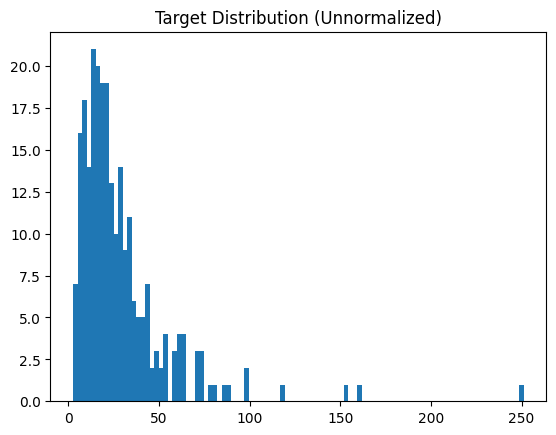

In [80]:
plt.hist((targs * 1e4).numpy(), bins=100)
plt.title("Target Distribution (Unnormalized)")


Text(0.5, 1.0, 'Percent Distribution (Unnormalized)')

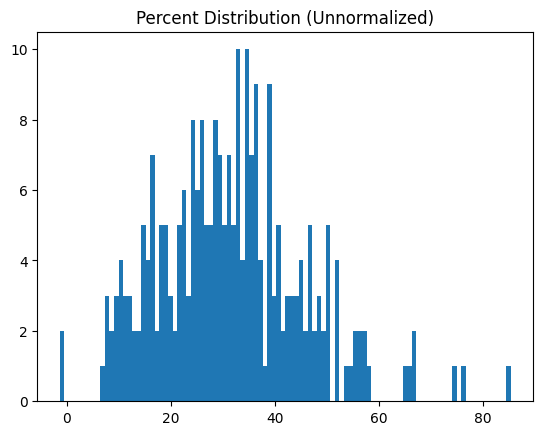

In [81]:
plt.hist((percents*1e4).detach().numpy(), bins=100)
plt.title("Percent Distribution (Unnormalized)")

Text(0, 0.5, 'Absolute Error')

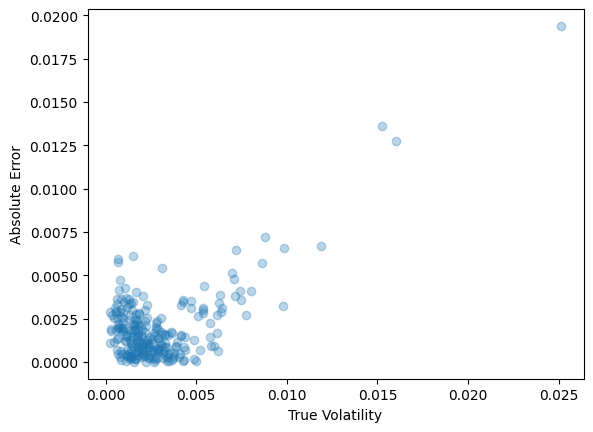

In [82]:
plt.scatter(targs.numpy(), (percents.detach() - targs).abs().numpy(), alpha=0.3)
plt.xlabel("True Volatility")
plt.ylabel("Absolute Error")
